In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Recommendation systems: Deep Model

This model is made up of feature layers that have users, movies and movie genres embedings followed by a neural network with dense layers and finally one output that is the rating prediction that input user(id) could assign to input movie(id).

**Inputs**
* **User id**: Really this is traducet as a sequence because embedding layers only can manage sequenced identifiers.
* **Movie id**: Idem to User id.
* **Movie genres**: One column by genre.

**Output**
*  **Rating prediction** that user could assign to movie.

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)
* [Movie lens datasets](https://grouplens.org/datasets/movielens/)
* [Recommendation Systems Benchmarks](https://paperswithcode.com/task/recommendation-systems)

## Required libraries

In [48]:
import sys
sys.path.append('../src')

import math
import numpy as np
import pandas as pd
import tensorflow as tf

from util import tf_detected_devices, \
                 tf_version, \
                 plot_model, \
                 Config, \
                 LoggerFactory, \
                 create_path

from callback import MetricsPlotter

from data import DataFrameDataGenerator

from recommendation import UserMovieGenderEmbeddingDenseModelFactory, \
                           RecommendationsDataGenerator

from spark import SparkSessionFactory, \
                  read_csv, \
                  column_values, \
                  train_test_split, \
                  PageSet, \
                  get_columns, \
                  get_rows

import pyspark.sql.types as t
import pyspark.sql as s
import pyspark.sql.functions as f

## Logger config

In [31]:
config = Config(path='../config/config.yaml')
LoggerFactory(config['logger']).create()

<RootLogger root (INFO)>

## Config parameters

Setup test_mode variable to enable or disable model train before check their prediction precision:

In [32]:
train_model = True

## Check environment

**Step 1**: Make sure that nvidia driver is installed runing next command:

In [33]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

NVIDIA GeForce RTX 3080, 10240 MiB


**Note:** If this shows a GPU model and memory size, that's all right, otherwise make suze that has the nvidia driver installed.

**Step 2**: Let's check tensorflow version:

In [34]:
tf_version()

'Tensorflow version: 2.8.0'

**Step 3**: Let's check devices that tensorflow detect:

In [35]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,
1,/device:GPU:0,GPU,488M,"device: 0, name: NVIDIA GeForce RTX 3080, pci ..."


In [36]:
tf.debugging.set_log_device_placement(False)

**Step 4**: Make sure that tensorflow detect cuda libs and GPU devices.

In [37]:
tf.test.is_built_with_cuda()

True

In [38]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Prepare model input data

**Step 1**: Create a predefined spark session. this is used to create a pipeline that build the model input features. 

In [39]:
session = SparkSessionFactory.create()
session

In [40]:
session.sparkContext.getConf().getAll()

[('spark.app.startTime', '1645981041991'),
 ('spark.executor.instances', '12'),
 ('spark.sql.warehouse.dir',
  'file:/home/adrian/development/machine-learning/recommendations/user-movie-genres-model/spark-warehouse'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.memory', '1G'),
 ('spark.app.name', 'recommendations'),
 ('spark.driver.host', 'skynet'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.id', 'local-1645981042022'),
 ('spark.master', 'local[*]'),
 ('spark.driver.port', '37985'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.memory', '4G'),
 ('spark.ui.showConsoleProgress', 'true')]

**Note**: When create a spark session this run a new spark cluster with one instance in localhost. You can monitor instance jobs clicking the **Spark UI** link. 

**Step 2**: Load raw dataset to a spark dataset. 

In [41]:
TEMP_PATH = './temp'
TRAIN_PATH = f'{TEMP_PATH}/train'
VAL_PATH = f'{TEMP_PATH}/val'
TEST_PATH = f'{TEMP_PATH}/test'

In [44]:
train_set = read_csv(session, f'{TRAIN_PATH}/*.csv')
val_set   = read_csv(session, f'{VAL_PATH}/*.csv')
test_set  = read_csv(session, f'{TEST_PATH}/*.csv')

print(f'Train set size: {"{:,}".format(train_set.count())} samples.')
print(f'Validation set size: {"{:,}".format(val_set.count())} samples.')
print(f'Test set size: {"{:,}".format(test_set.count())} samples.')

Train set size: 70,288 samples.
Validation set size: 20,198 samples.
Test set size: 8,851 samples.


**Step 3:** Let's see min and max value of rating column.

In [45]:
min_max = train_set.agg(f.min('rating'), f.max('rating')).collect()[0]
min_rating, max_rating = min_max[0], min_max[1]

print('Ratting - min: ', min_rating, 'max:', max_rating)

Ratting - min:  0.5 max: 5.0


**Step 4:** Let's see all dataset columns.

In [46]:
class ColumnService:
    def __init__(self, columns):
        excluded_columns = ['user_id', 'movie_id']
        self.labels = ['rating']

        features = list(set(columns) - set(self.labels) - set(excluded_columns))
        features = sorted(features, key=lambda x: 'gen_' in x)

        self.gender_features = [c for c in features if 'gen_' in c]
        self.emb_features = [c for c in features if '_seq' in c]
        self.emb_features = sorted(self.emb_features, key=lambda x: 'user' in x, reverse=True)
   
        self.features = self.emb_features + self.gender_features

column_manager = ColumnService(train_set.columns)

**Step 5**: Calculate train, val batch_size and plot interval.

In [49]:
steps             = 100
epochs            = 20
plot_interval     = math.floor(steps / 10)

train_batch_size  = math.floor(train_set.count() / steps)
val_batch_size    = math.floor(val_set.count() / steps)
evaluate_interval = plot_interval + 1


print(f'Train Batch Size      : {"{:,}".format(train_batch_size)}.')
print(f'Validation Batch Size : {"{:,}".format(val_batch_size)}.')
print('Plot Interval         :', plot_interval)
print('Evaluate Interval     :', evaluate_interval)
print('Epochs                :', epochs)

Train Batch Size      : 702.
Validation Batch Size : 201.
Plot Interval         : 10
Evaluate Interval     : 11
Epochs                : 20


In [50]:
train_generator = RecommendationsDataGenerator(
    train_set,
    train_batch_size,
    column_manager,
    shuffle = True,
    name    = 'train'
)

val_generator = RecommendationsDataGenerator(
    val_set,
    val_batch_size,
    column_manager,
    shuffle = False,
    name    = 'val'
)

2022-02-27 13:58:47 INFO Page Size: 702
2022-02-27 13:58:47 INFO Pages Count: 101
2022-02-27 13:58:47 INFO Total elements: 70288
2022-02-27 13:58:47 INFO Page Size: 201
2022-02-27 13:58:47 INFO Pages Count: 101
2022-02-27 13:58:47 INFO Total elements: 20198


In [51]:
n_users = train_set.select('user_seq') \
            .union(val_set.select('user_seq')) \
            .union(test_set.select('user_seq')) \
            .distinct() \
            .count()

n_movies = train_set.select('movie_seq') \
            .union(val_set.select('movie_seq')) \
            .union(test_set.select('movie_seq')) \
            .distinct() \
            .count()

print(f'Train set size: {"{:,}".format(n_users)}.')
print(f'Validation set size: {"{:,}".format(n_movies)}.')

Train set size: 610.
Validation set size: 8,454.


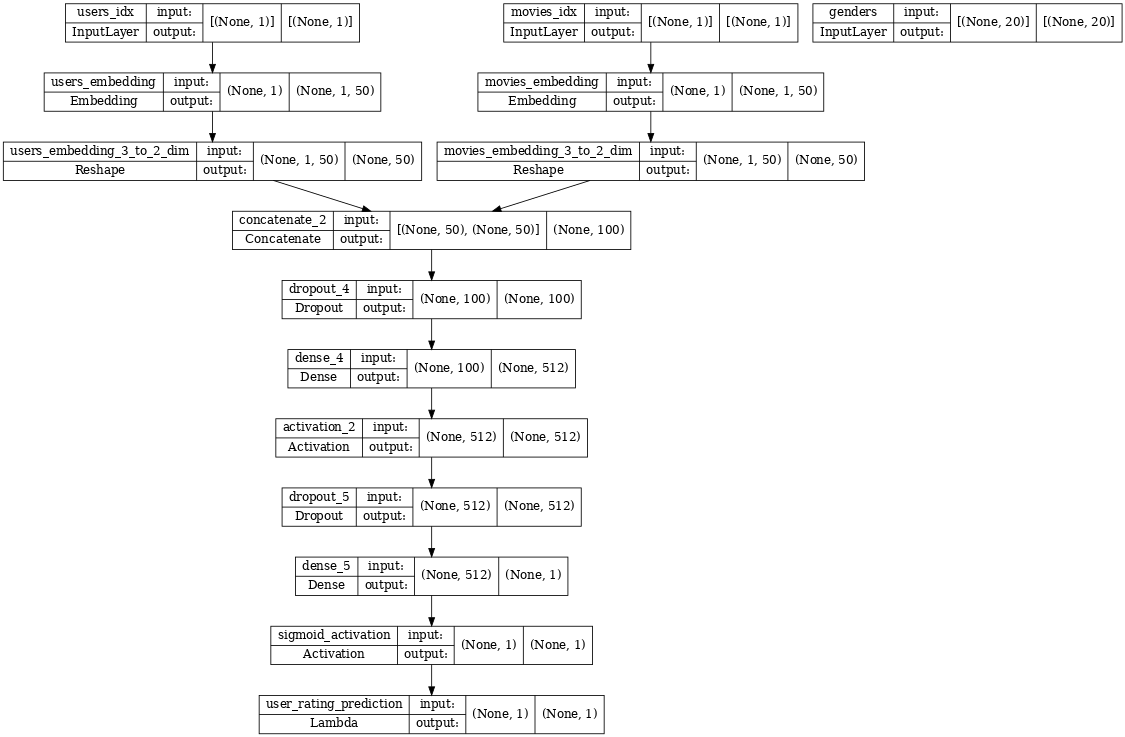

In [53]:
model = UserMovieGenderEmbeddingDenseModelFactory.create(
    n_users,
    n_movies,
    n_genders           = len(column_manager.gender_features),
    min_rating          = min_rating, 
    max_rating          = max_rating,
    user_n_min_factors  = 50,
    movie_n_min_factors = 50,
    lr                  = 0.001,
    units               = [512, 512, 512, 512],
    dropout             = [0.5, 0.5, 0.5, 0.5]
)

plot_model(model, rankdir="TB")

In [54]:
model.summary()

Model: "Embedding_Feature_Layers_Plus_Dense_Layer_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 users_idx (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 movies_idx (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 users_embedding (Embedding)    (None, 1, 50)        30500       ['users_idx[0][0]']              
                                                                                                  
 movies_embedding (Embedding)   (None, 1, 50)        422700      ['movies_idx[0][0]']             
                                                    

In [55]:
if train_model:
    history = model.fit_generator(
        generator       = train_generator,
        validation_data = val_generator,
        epochs          = epochs,
        verbose         = 1, 
        callbacks       = [
            MetricsPlotter(
                validation_generator  = val_generator, 
                metrics_names         = ['loss'],
                plot_interval         = plot_interval,
                evaluate_interval     = evaluate_interval,
                batch_size            = train_batch_size,
                val_batch_size        = val_batch_size
            )
        ]
    )

loss
Epoch 1/20


InternalError: Graph execution error:

Detected at node 'Embedding_Feature_Layers_Plus_Dense_Layer_Model/dense_4/MatMul' defined at (most recent call last):
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 149, in start
      self.asyncio_loop.run_forever()
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/tornado/ioloop.py", line 690, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/tornado/ioloop.py", line 743, in _run_callback
      ret = callback()
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/tornado/gen.py", line 787, in inner
      self.run()
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/tornado/gen.py", line 748, in run
      yielded = self.gen.send(value)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 365, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 543, in execute_request
      self.do_execute(
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/tornado/gen.py", line 209, in wrapper
      yielded = next(result)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2876, in run_cell
      result = self._run_cell(
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2922, in _run_cell
      return runner(coro)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3145, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3337, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-55-000925bb503f>", line 2, in <module>
      history = model.fit_generator(
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/engine/training.py", line 2209, in fit_generator
      return self.fit(
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/adrian/.conda/envs/recommendations/lib/python3.8/site-packages/keras/layers/core/dense.py", line 219, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'Embedding_Feature_Layers_Plus_Dense_Layer_Model/dense_4/MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node Embedding_Feature_Layers_Plus_Dense_Layer_Model/dense_4/MatMul}}]] [Op:__inference_train_function_2082]

Check model loss after training process:

In [ ]:
def evaluate_xy_model(model, column_manager, data_frame, batch_size):
    data_generator = RecommendationsDataGenerator(
        data_frame,
        column_manager.features,
        column_manager.labels,
        data_frame.count(),
        shuffle=False
    )
    X, y = data_generator[0]
    return model.evaluate(X, y, batch_size=batch_size, verbose=0)

In [ ]:
val_loss = evaluate_xy_model(model, column_manager, val_set, val_batch_size)
val_loss

Save the weights tthat model has learned:

In [ ]:
## WEIGHTS_PATH = create_path(f'../weights')
WEIGHTS_FILE = f'{WEIGHTS_PATH}/user_movie_genders_deep_model_weights_val_loss_{val_loss}.h5'
model.save_weights(WEIGHTS_FILE)

In [29]:
session.stop()